In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from ShallowTree.ShallowTree import ShallowTree as ShallowTree_
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.pruning import *
from intercluster.experiments import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

color_dict = {
    0: cmap(1),
    1: cmap(5),
    2: cmap(7),
    3: cmap(6),
    4: cmap(3),
    5: cmap(2),
    6: cmap(4),
    7: cmap(0)
}
color_dict[-1] = 'grey'

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (although this will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

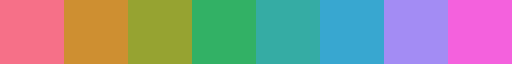

In [4]:
cmap

## Example Setting

The following notebook is intended to work with a simple setting in which the methods and 
algorithms for this library may be tested and experimented with. 

In [5]:
'''
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=[1000,700,300], cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)
'''

'\nn = 2000\nm = 2\nk = 3\n\nrandom_state = 170\ndata, labels = datasets.make_blobs(\n    n_samples=[1000,700,300], cluster_std=[1.0, 2.5, 0.5], random_state=seed\n)\ndata = preprocessing.MinMaxScaler().fit_transform(data)\n'

In [6]:
n = 10000
m = 2
k = 4

cluster_centers = np.array([
    [0,1],
    [0.25, 0.25],
    [0.9, 0.75],
    [1.55,0.1],
])

data, labels = datasets.make_blobs(
    n_samples=n, centers = cluster_centers, cluster_std=0.125, random_state=seed
)
#data = preprocessing.MinMaxScaler().fit_transform(data)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_18208/2529989316.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)


Text(0, 0.5, 'y')

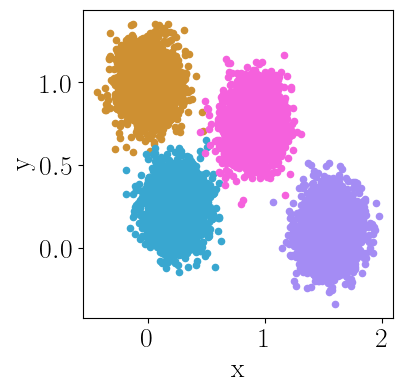

In [7]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
uni_labels = np.unique(labels)
for l in uni_labels:
    idx = np.where(labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)

ax.set_xlabel('x')
ax.set_ylabel('y')

### Kmeans Reference Clustering

Everything starts with KMeans, and from there we can build interpretable models. 

In [20]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)

# To handle situations where points may belong to multiple clusters, throughout 
# the repository we'll take the convention that labels are lists of 
# label sets e.g. [{1}, {1,2}, {3}], so that the item at index i describes the cluster membership 
# of the data point at index i. 
kmeans_labels = labels_format(kmeans.labels_)

# Sometimes, this is more usefully represented as a label assignment matrix, which is 
# (usually) an n x k array where each (i,j) entry is True if point i belongs to cluster j 
# and false otherwise. For both this and the previous representation,
#  we implement helper functions to interface with more standard conventions. 
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)

# Computes the normalized cost of the clustering
cost = kmeans_cost(
    data,
    kmeans.cluster_centers_,
    kmeans_assignment, average = True,
    normalize= True
)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_17228/4034837231.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)


Text(0, 0.5, 'y')

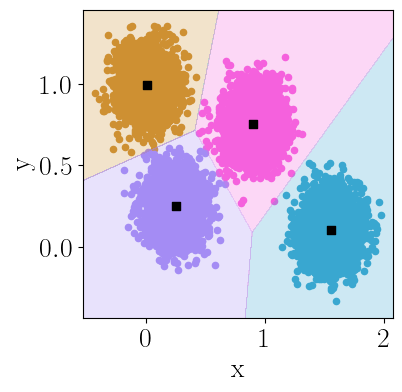

In [21]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labels = np.unique(kmeans.labels_)
for l in uni_labels:
    idx = np.where(kmeans.labels_ == l)[0]
    ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)

plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000, label_array = True, color_dict = color_dict)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')

### Basic Decision Tree

In [24]:
tree1 = DecisionTree(max_leaf_nodes = 5)
tree1.fit(data, kmeans_labels)
y_id3 = flatten_labels(tree1.predict(data))

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_17228/1279848519.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)


Text(0, 0.5, 'y')

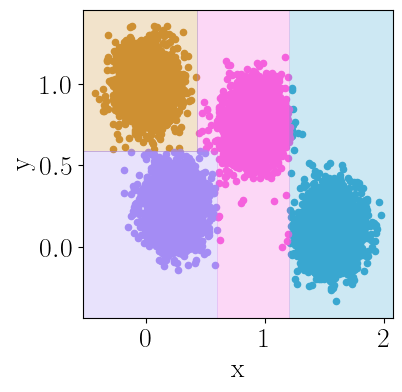

In [25]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labels = np.unique(y_id3)
for l in uni_labels:
    idx = np.where(y_id3 == l)[0]
    ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)

plot_decision_boundaries(tree1, data, ax = ax, resolution = 1000, color_dict = color_dict)

ax.set_xlabel('x')
ax.set_ylabel('y')

### IMM

We also interface with an implementation for the Iterative Mistake Minimization algorithm. 
This is implemented by [Frost et al.](https://github.com/navefr/ExKMC), and is running in the 
backend of the code below. We build upon their work by allowing for additional visualizations 
and other tree measurements/attributes.

In [26]:
# As long as imm = True, ExkmcTree will produce an IMM tree if  given max_leaf_nodes = n_clusters.
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = 5,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_label_array = flatten_labels(exkmc_labels)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_17228/84577022.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)


Text(0, 0.5, 'y')

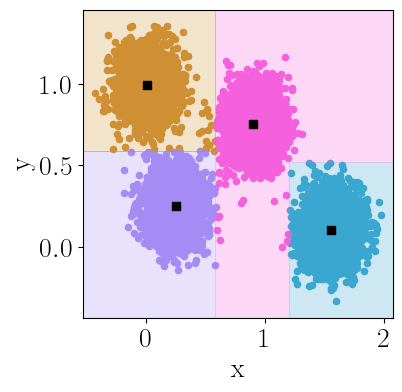

In [27]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labels = np.unique(exkmc_label_array)
for l in uni_labels:
    idx = np.where(exkmc_label_array == l)[0]
    ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)

plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000, color_dict = color_dict)

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'k', s = 30, marker = 's')

ax.set_xlabel('x')
ax.set_ylabel('y')

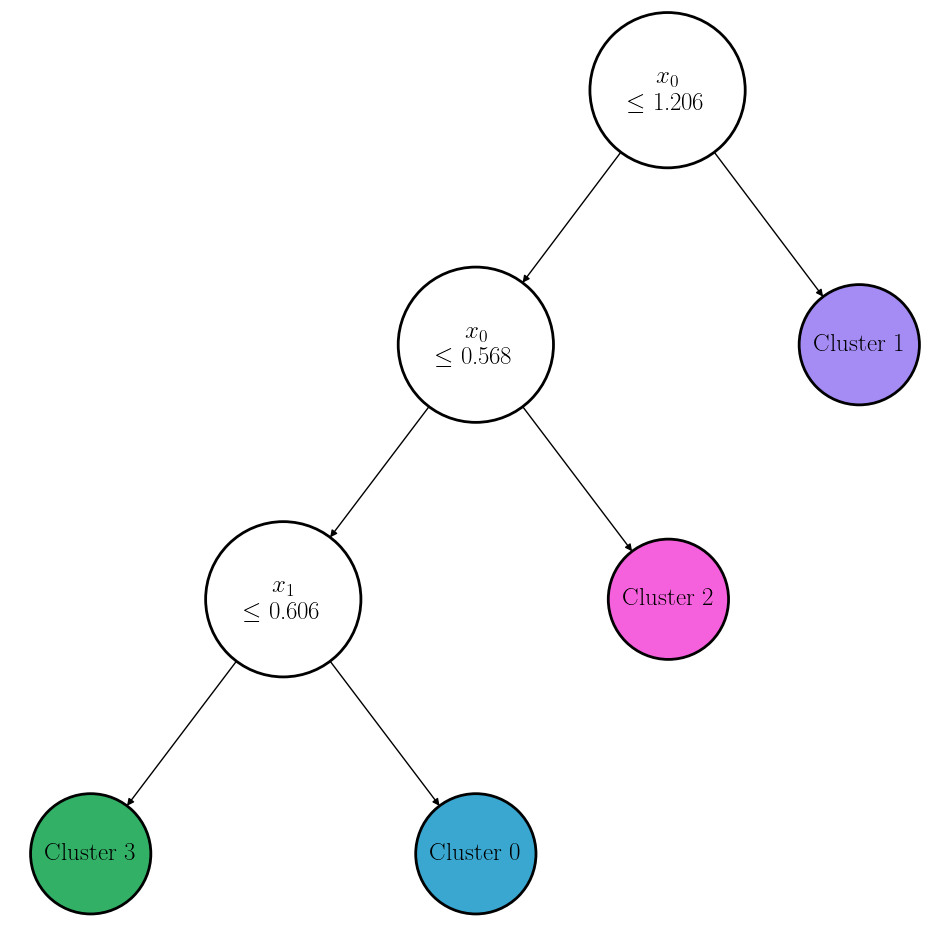

In [67]:
# Draw the associated IMM decision tree:
draw_tree(exkmc_tree.root, cmap = cmap_subset2)

### Shallow Tree

The shallow tree algorithm designed by Laber et al. works by training a tree which is 
penalized for having large depth.

In [86]:
shallow_tree = ShallowTree(n_clusters = k, depth_factor = 0.0, kmeans_random_state=seed)
shallow_tree.fit(data)
shallow_labels = shallow_tree.predict(data, leaf_labels = False)
shallow_label_array = flatten_labels(shallow_labels)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_17228/1884832545.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)


Text(0, 0.5, 'y')

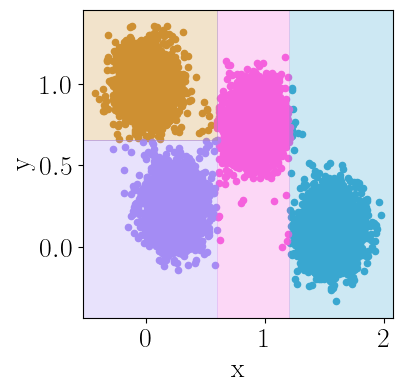

In [87]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
uni_labels = np.unique(shallow_label_array)
for l in uni_labels:
    idx = np.where(shallow_label_array == l)[0]
    ax.scatter(data[idx,0], data[idx,1], c = color_dict[l], alpha = 1, s = 20)

plot_decision_boundaries(shallow_tree, data, ax = ax, resolution = 1000, color_dict = color_dict)
ax.set_xlabel('x')
ax.set_ylabel('y')

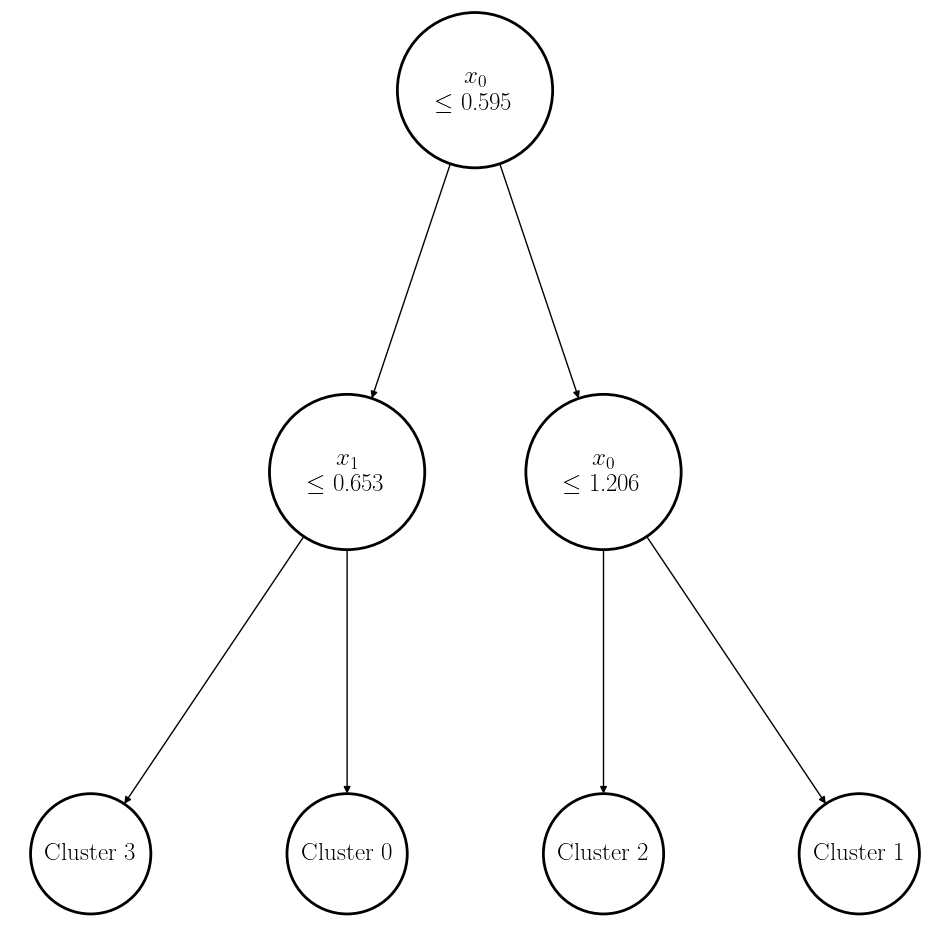

In [88]:
draw_tree(shallow_tree.root)

### Explanation Tree

Next, we show an implementation for the what we call the Explanation Tree algorithm, 
designed by Bandyapadhyay et al. in their work "How to find a good explanation for clustering?"
The algorithm works by removing outliers during the training process, aiming to find a minimal 
number of points to remove so that the resulting tree exactly replicates KMeans on everything 
that remains.

In [30]:
import time

In [60]:
exp_tree = ExplanationTree(num_clusters = k)
start = time.time()
exp_tree.fit(data, dbscan_labels)
end = time.time()
exp_labels = exp_tree.predict(data, remove_outliers = True)

# After fitting, we can observe its outliers attribute to see what was removed.
outliers = list(exp_tree.outliers)
non_outliers = [i for i in range(len(data)) if i not in outliers]
exp_label_array = flatten_labels([exp_labels[l] for l in non_outliers])

In [62]:
print("Time taken: " + str(end - start) + "s")

Time taken: 0.4458460807800293s


Text(0, 0.5, 'y')

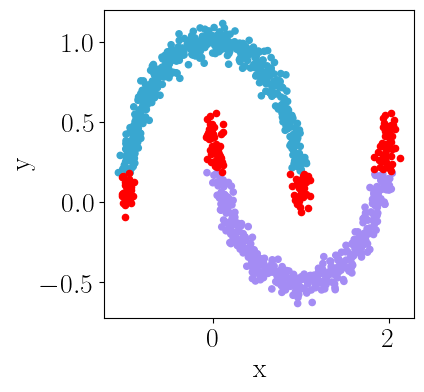

In [63]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[non_outliers,0], data[non_outliers,1], c = exp_label_array, cmap = cmap_subset4, s = 20)

# Removed outlier points are displayed in red!
ax.scatter(data[outliers,0], data[outliers,1], c = 'red', s = 20)

ax.set_xlabel('x')
ax.set_ylabel('y')

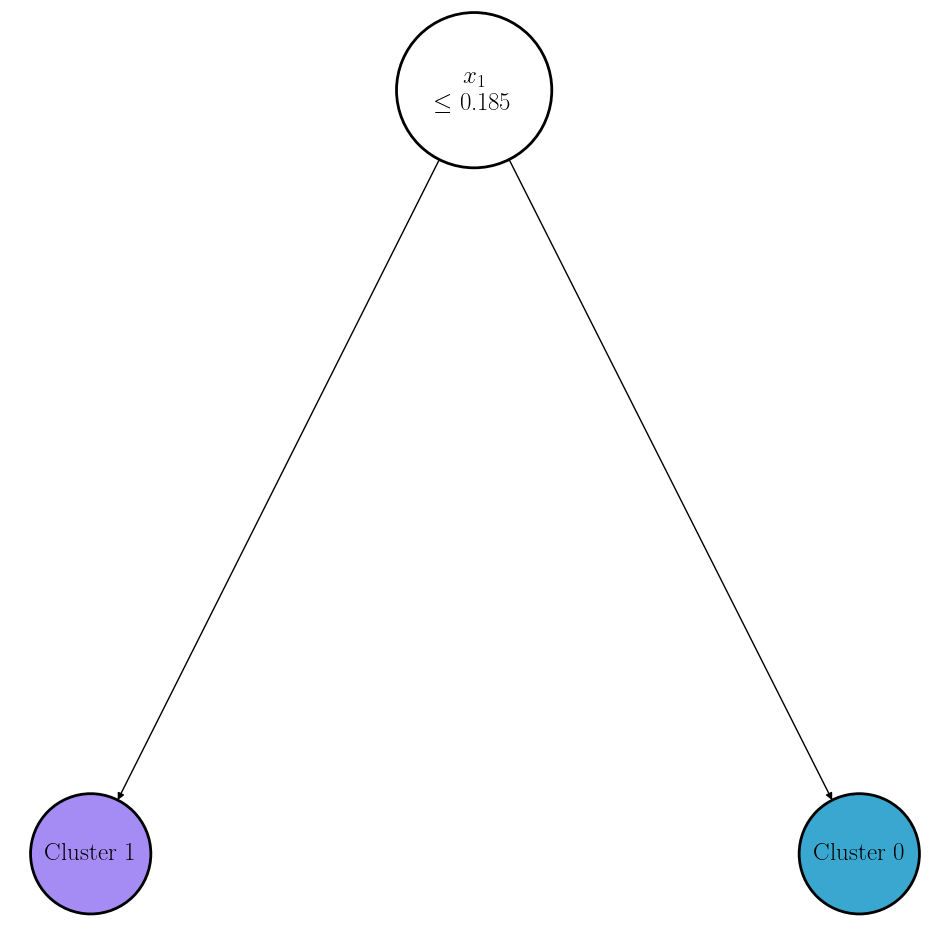

In [64]:
draw_tree(exp_tree.root, cmap = cmap_subset4)

In [36]:
def reduction(data, labels, s):
    clusters = np.unique(labels)
    d = data.shape[1]
    marked = np.zeros(data.shape[0], dtype = bool)
    for i in clusters:
        cluster_points = np.where(labels == i)[0]
        cluster_size = len(cluster_points)
        n_mark = min(s + 1, cluster_size)
        for j in range(d):
            sorts = np.argsort(data[cluster_points,j])
            L = sorts[:n_mark]
            R = sorts[-n_mark:]
            marked[L] = True
            marked[R] = True

    return data[marked,:], labels[marked]

In [51]:
data_, labels_ = reduction(data, labels, 10)

In [52]:
len(data_)

127

Text(0, 0.5, 'y')

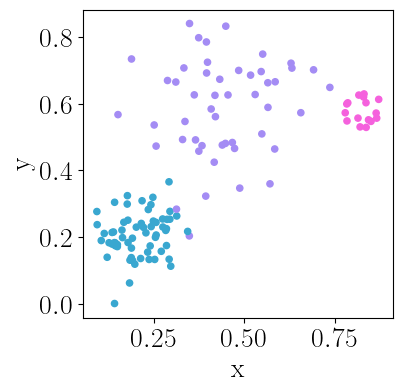

In [53]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data_[:,0], data_[:,1], c = labels_, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

## Decision Forest

Finally, we show how to create a basic decision forest, trained with a random collection 
of one-versus-all sklearn decision trees. 

In [45]:
np.random.seed(918713)

In [46]:
# Our implementation allows for certain subsets of features to be paired together, 
# meaning they will always be used together in the trees.
feature_pairings = [[0, 1]]

# Likewise we also specify a maximum depth for the trees. 
forest_tree_params = {
    'max_depth' : 2
}

# The following trains a random forest of 100 trees on random 75% portions of the data.
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)

data_labels = labels_format(kmeans.labels_)
forest.fit(data, data_labels)

In [48]:
# Now we have a trained forest with a lot of rules, so we'll need to prune it 
# with a distorted greedy selection process. 

# We first give a kmeans cost objective to the grid search algorithm. This is used to 
# break ties if multiple solutions exist. 
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    average = False,
    normalize = True
)

# We then tell the forest to prune, and give 3 rules which cover 90% of the data. 
# We also specify a search range for lambda values.
forest.prune(
    n_rules = 3,
    frac_cover = 0.9,
    n_clusters = 3,
    X = data, 
    y = labels_format(kmeans.labels_),
    objective = prune_objective,
    lambda_search_range = np.linspace(0,5,51)
    
)

# The resulting set of predicted labels may be obtained with the pruned predict method. 
prune_predictions = forest.pruned_predict(data, rule_labels = False)

In [50]:
# We'll pull the pruned decision set out of the forest.
pruned_decision_set = [forest.decision_set[i] for i in forest.pruned_indices]
pruned_decision_set_labels = [forest.decision_set_labels[i] for i in forest.pruned_indices]

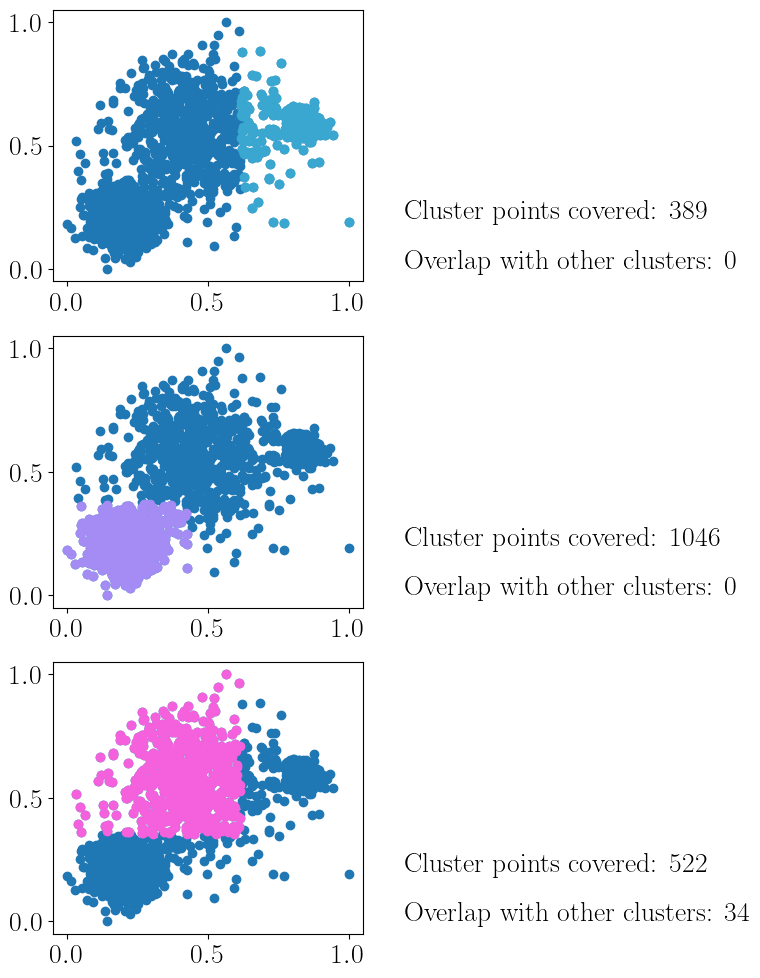

In [ ]:
# Then visualize what's covered by each of the rules:
ld = len(pruned_decision_set)
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(pruned_decision_set):
    r_label = list(forest.decision_set_labels[forest.pruned_indices[i]])[0]
    indices = satisfies_conditions(data, condition_list)
    points_covered = np.sum(kmeans.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(kmeans.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap_subset(list(pruned_decision_set_labels[i])[0]))
        ax[i].text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax[i].text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap_subset(list(pruned_decision_set_labels[i])[0]))
        ax.text(x = 1.2, y = 0.2, s = "Cluster points covered: " + str(points_covered), ha = 'left')
        ax.text(x = 1.2, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

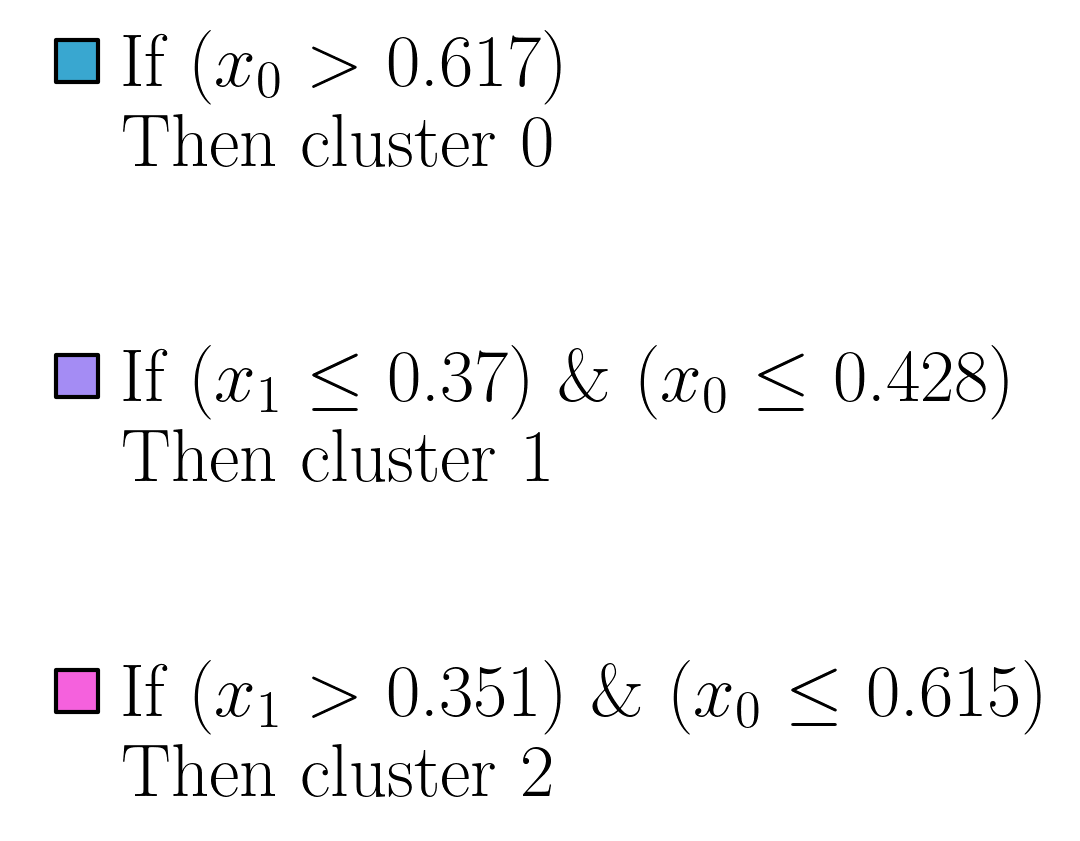

In [53]:
# Finally, we plot the pruned set of rules.
pruned_set = [forest.decision_set[i] for i in forest.pruned_indices]
pruned_rule_labels = [forest.decision_set_labels[i] for i in forest.pruned_indices]
plot_decision_set(
    decision_set = pruned_set,
    rule_labels = pruned_rule_labels,
    cmap = cmap_subset,
)

### Entropy Counter Example

In [5]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [6]:
n = 1000
m = 2
k = 4

cluster_centers = np.array([
    [0,1],
    [0.25, 0.25],
    [0.9, 0.75],
    #[1.55,0.1],
])

data, labels = datasets.make_blobs(
    n_samples=n, centers = cluster_centers, cluster_std=0.125, random_state=seed
)

# Outliers:
data = np.vstack((data, np.array([[0.25,3.5],[0.75,3.5]])))
labels = np.hstack((labels, np.array([3,3])))

Text(0, 0.5, 'y')

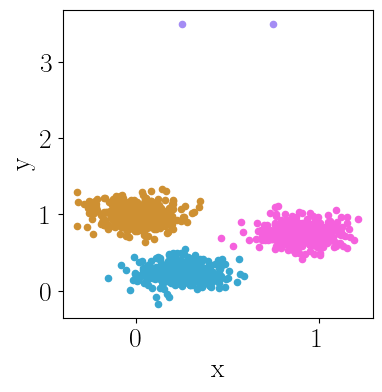

In [7]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labels = np.unique(labels)
for l in uni_labels:
    idx = np.where(labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [ ]:
# KMeans
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)

In [35]:
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)

Text(0, 0.5, '$x_2$')

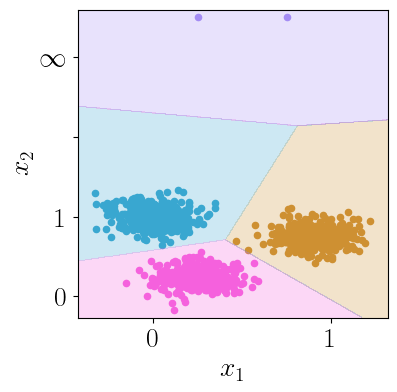

In [9]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
uni_labels = np.unique(kmeans.labels_)
for l in uni_labels:
    idx = np.where(kmeans.labels_ == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)

plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000, label_array = True, color_dict = color_dict)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#plt.savefig('../figures/examples/outliers_kmeans.png', bbox_inches = 'tight')

In [10]:
n_rules = 4

# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, kmeans_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = k, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# IMM
imm_tree = ExkmcTree(k = k, kmeans = kmeans, max_leaf_nodes = n_rules)
imm_tree.fit(data)
imm_labels = imm_tree.predict(data, leaf_labels = False)
imm_labels_ = flatten_labels(imm_labels)
imm_leaf_labels = imm_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
imm_rule_assignment = labels_to_assignment(imm_leaf_labels, n_labels = k, ignore = {-1})
imm_data_to_rule_assignment = imm_tree.get_data_to_rules_assignment(data)
imm_data_to_cluster_assignment = imm_data_to_rule_assignment @ imm_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = k)
rem_tree.fit(data, kmeans_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = k, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
rule_miner = PointwiseMiner(samples = 10, prob_dim = 1/2, prob_mistake = 0.0)
dsclust = DSCluster(lambd = 1e6, n_rules = n_rules, rule_miner = rule_miner)
dsclust.fit(data, kmeans_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = k, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

In [11]:
n_mine = 20

lambdas = [
    1/n_mine,
    1/(2 * data.shape[1] * n_mine),
    1/(len(data) * (n_mine**2)),
    1/(len(data) * (n_mine**2)),
    k,
    1/(data.shape[0] * n_mine),
    1/(data.shape[0])
]


rule_miner = AssociationRuleMiner(max_rules = n_mine)
ids_set = IdsSet(lambdas = lambdas, rule_miner = rule_miner)
ids_set.fit(data, kmeans_labels)
ids_set_labels = ids_set.predict(data)
#ids_set_labels_ = flatten_labels(ids_set_labels)
ids_set_labels_ = np.array([min(labs) for labs in ids_set_labels])
ids_set_rule_assignment = labels_to_assignment(ids_set.decision_set_labels, n_labels = k, ignore = {-1})
ids_set_data_to_rule_assignment = ids_set.get_data_to_rules_assignment(data)
ids_set_data_to_cluster_assignment = ids_set_data_to_rule_assignment @ ids_set_rule_assignment

Lambdas found: [0.05, 0.0125, 2.4950099800399203e-06, 2.4950099800399203e-06, 4, 4.99001996007984e-05, 0.000998003992015968]


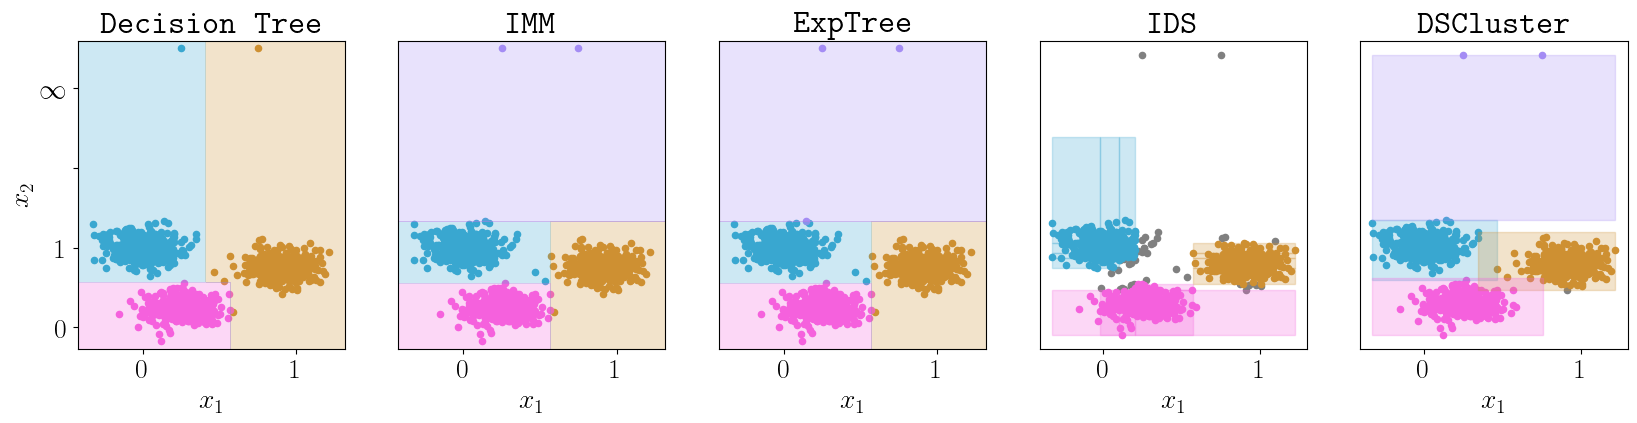

In [36]:
fig,axs = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4), dpi = 100)

# Decision Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(dtree_labels_ == l)[0]
    axs[0].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(dtree, data, color_dict, ax = axs[0], resolution = 1000, label_array = False)
axs[0].set_xlabel(r'$x_1$')
axs[0].set_title(r"\texttt{Decision Tree}")

# IMM
uniqie_labs = np.unique(imm_labels_)
for l in uniqie_labs:
    idx = np.where(imm_labels_ == l)[0]
    axs[1].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(imm_tree, data, color_dict, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel(r'$x_1$')
axs[1].set_title(r"\texttt{IMM}")

# Removal Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(rem_tree_labels_ == l)[0]
    axs[2].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(rem_tree, data, color_dict, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel(r'$x_1$')
axs[2].set_title(r"\texttt{ExpTree}")

# IDS
uniqie_labs = np.unique(ids_set_labels_)
for l in uniqie_labs:
    idx = np.where(ids_set_labels_ == l)[0]
    axs[3].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(ids_set, data, color_dict, axs[3])
axs[3].set_xlabel(r'$x_1$')
axs[3].set_title(r"\texttt{IDS}")

# Decision Set Clustering
uniqie_labs = np.unique(dsclust_labels_)
for l in uniqie_labs:
    idx = np.where(dsclust_labels_ == l)[0]
    axs[4].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(dsclust, data, color_dict, axs[4])
axs[4].set_xlabel(r'$x_1$')
axs[4].set_title(r"\texttt{DSCluster}")


y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
axs[0].set_yticks(y_tick_locations)
axs[0].set_yticklabels(y_tick_labels)
axs[0].set_ylabel(r'$x_2$')

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)
axs[4].yaxis.set_visible(False)

plt.savefig("../figures/examples/counter_example.png", bbox_inches = 'tight', dpi = 300)

Text(0, 0.5, '$x_2$')

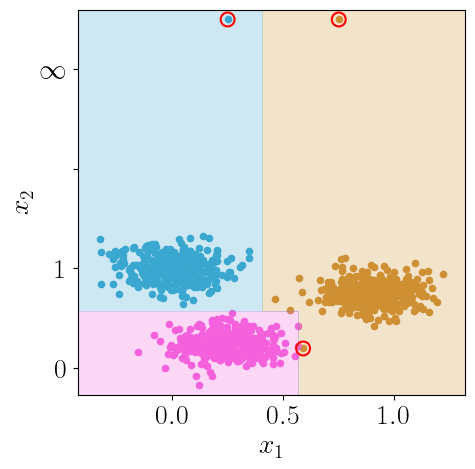

In [ ]:
algname = "ids"
alg = ids_set
alg_labels = ids_set_labels_
title = r"\texttt{ExpTree}"

fig,ax = plt.subplots(figsize = (5,5), dpi = 100)

uni_labs = np.unique(alg_labels)
for l in uni_labs:
    idx = np.where(alg_labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(alg, data, color_dict, ax = ax, resolution = 1000, label_array = False)

# Mark misclassified points
#misclassified = np.where(alg_labels != kmeans_labels_)[0]
#ax.scatter(data[misclassified,0], data[misclassified,1], facecolors = 'none', edgecolors = 'red', s = 100, linewidths = 1.5)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title(title)
#plt.savefig("../figures/examples/outliers/" + algname + ".png", bbox_inches = 'tight', dpi = 300)


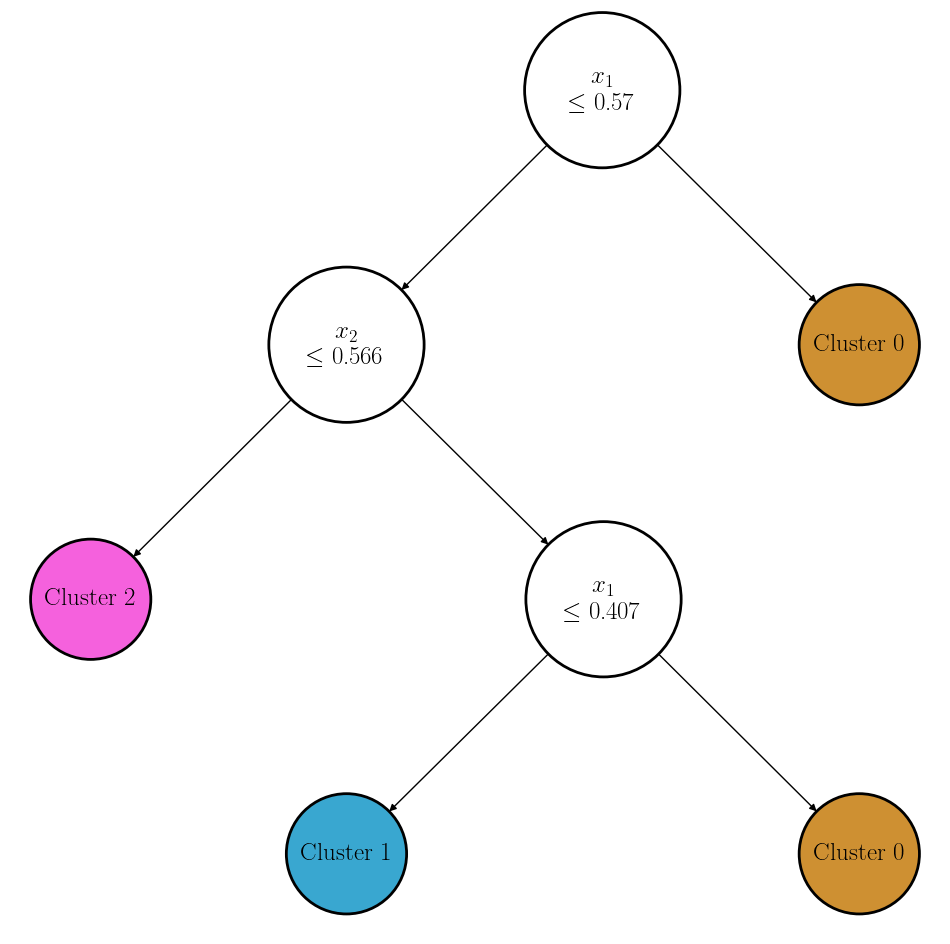

In [44]:
draw_tree(
    root = alg.root,
    color_dict = color_dict,
    feature_labels = [r'$x_1$', r'$x_2$'],
    output_file = "../figures/examples/outliers/" + algname + "_rules.png"
)

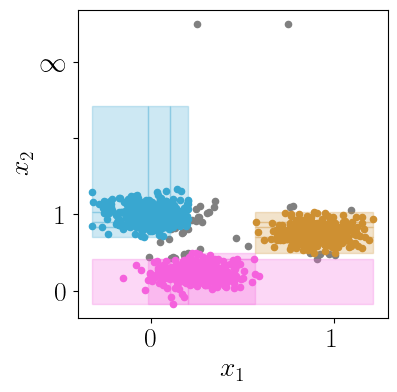

In [52]:
algname = "ids"
alg = ids_set
alg_labels = ids_set_labels_
#title = r"\texttt{IDS}"

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labs = np.unique(alg_labels)
for l in uni_labs:
    idx = np.where(alg_labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(alg, data, color_dict, ax)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title(title)
plt.savefig("../figures/examples/outliers/" + algname + ".png", bbox_inches = 'tight', dpi = 300)

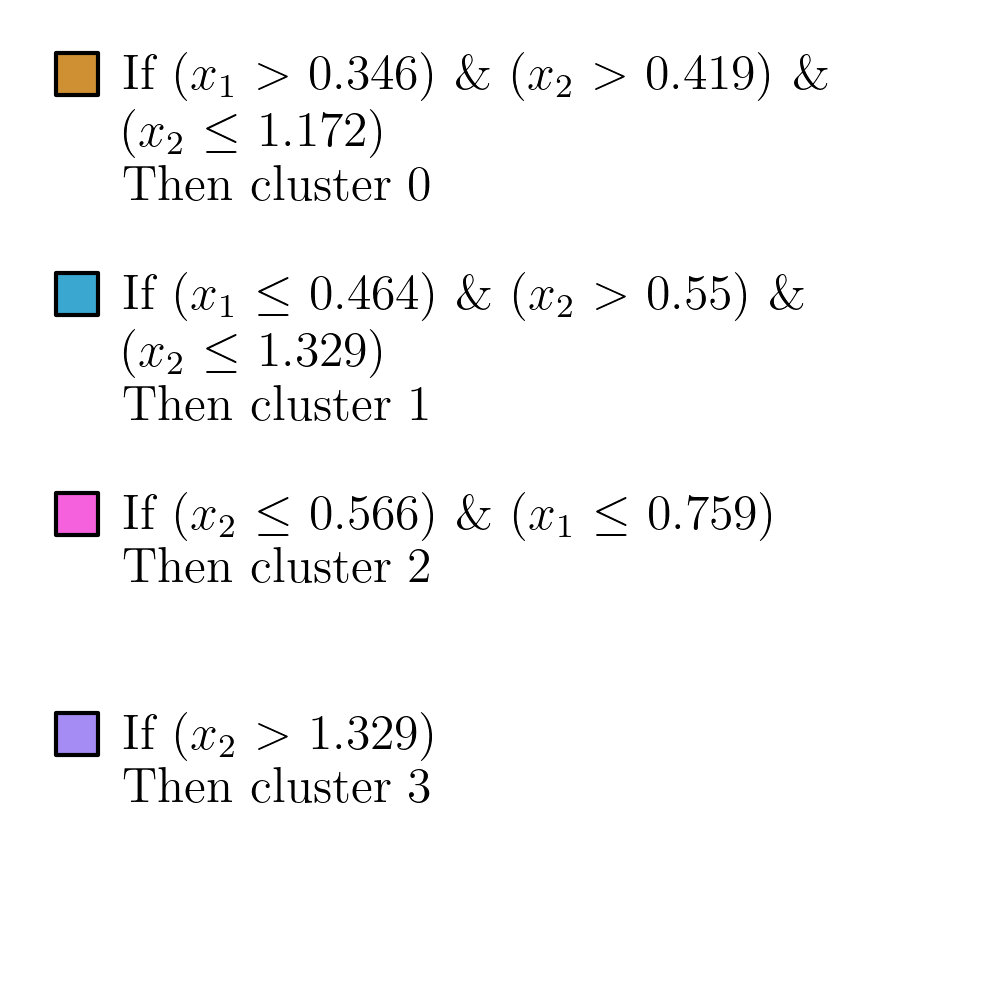

In [51]:
plot_decision_set(
    decision_set = alg.decision_set,
    rule_labels = alg.decision_set_labels,
    color_dict = color_dict,
    feature_labels = [r'$x_1$', r'$x_2$'],
    size_factor = 1,
    filename = "../figures/examples/outliers/" + algname + "_rules.png",
)

In [ ]:
for algorithm in [dtree, imm_tree, rem_tree, dsclust, ids_set]:
    fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

fig,axs = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4), dpi = 100)

# Decision Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(dtree_labels_ == l)[0]
    axs[0].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(dtree, data, color_dict, ax = axs[0], resolution = 1000, label_array = False)
axs[0].set_xlabel(r'$x_1$')
axs[0].set_title("Decision Tree")

# IMM
uniqie_labs = np.unique(imm_labels_)
for l in uniqie_labs:
    idx = np.where(imm_labels_ == l)[0]
    axs[1].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(imm_tree, data, color_dict, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel(r'$x_1$')
axs[1].set_title("IMM")

# Removal Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(rem_tree_labels_ == l)[0]
    axs[2].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(rem_tree, data, color_dict, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel(r'$x_1$')
axs[2].set_title("Min. Removal")

# IDS
uniqie_labs = np.unique(ids_set_labels_)
for l in uniqie_labs:
    idx = np.where(ids_set_labels_ == l)[0]
    axs[3].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(ids_set, data, color_dict, axs[3])
axs[3].set_xlabel(r'$x_1$')
axs[3].set_title("IDS")

# Decision Set Clustering
uniqie_labs = np.unique(dsclust_labels_)
for l in uniqie_labs:
    idx = np.where(dsclust_labels_ == l)[0]
    axs[4].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(dsclust, data, color_dict, axs[4])
axs[4].set_xlabel(r'$x_1$')
axs[4].set_title("DSCluster")


y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
axs[0].set_yticks(y_tick_locations)
axs[0].set_yticklabels(y_tick_labels)
axs[0].set_ylabel(r'$x_2$')

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)
axs[4].yaxis.set_visible(False)

plt.savefig("../figures/examples/counter_example.png", bbox_inches = 'tight', dpi = 300)